# Accumulated Local Effects (ALE)

In [1]:
!git clone https://github.com/Abdulrasheed1729/xai.git

Cloning into 'xai'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 414 (delta 11), reused 10 (delta 3), pack-reused 384 (from 1)
Receiving objects: 100% (414/414), 53.74 MiB | 24.61 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Updating files: 100% (273/273), done.


In [2]:
import math
from typing import Callable, Literal

import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
X, y = fetch_california_housing(as_frame=True, return_X_y=True)
train_df = pd.concat([X, y], axis=1).dropna() # Remove all rows with NaN values
X = train_df[X.columns]
y = train_df[y.name]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)
df = X.assign(MedHouseVal=y)
feature_names = X_train.columns.tolist()

In [4]:
numerical_transformer = Pipeline([
])
preprocessor = ColumnTransformer(
    transformers = [
        ('scaler', StandardScaler(), feature_names)
    ],
    remainder = "drop"
)


pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', MLPRegressor()),
])

In [5]:
pipe.fit(X_train, y_train)
print("Accuracy:", pipe.score(X_test, y_test))

Accuracy: 0.7817180345916585


# ALE estimation for a single feature
The explanations for the equations can be found in the [interpretable ml book](https://christophm.github.io/interpretable-ml-book/ale.html).

(1) First we estimate the uncentered effect:
$$
\hat{\tilde{f}}_{j,ALE}(\mathbf{x}) = \sum_{k=1}^{k_j(\mathbf{x})} \frac{1}{n_j(k)} \sum_{i: x_j^{(i)} \in N_j(k)} \left[\hat{f}(z_{k,j}, \mathbf{x}^{(i)}_{-j}) - \hat{f}(z_{k-1,j}, \mathbf{x}^{(i)}_{-j})\right]
$$
(2) Then we center the effect so that the mean effect is zero:
$$
\hat f_{j,\text{ALE}}(\mathbf{x}) = \hat{\tilde f}_{j,\text{ALE}}(\mathbf{x}) \;-\; \frac1n \sum_{i=1}^n \hat{\tilde f}_{j,\text{ALE}}\!\big(\mathbf{x}_j^{(i)}\big)
$$

### Homework part 2

In [6]:
def ale(X: pd.DataFrame, model: Callable, feature: str, grid_size: int = 20, bin_method: Literal["quantile", "linear"] = "quantile"):
    """Compute the accumulated local effect of a numeric continuous feature.
    This function divides the feature in question into grid_size intervals (bins)
    and computes the difference in prediction between the first and last value
    of each interval and then centers the results.

    Arguments:
        X (pd.DataFrame): A pandas DataFrame to pass to the model for prediction.
        model: (Callable) Any python model with a predict method that accepts X as input.
        feature (str): String, the name of the column holding the feature being studied.
        grid_size (int): An integer indicating the number of intervals into which the feature range is divided.

    Return:
        A pandas DataFrame containing for each bin: the size of the sample in it
        and the accumulated centered effect of this bin.
    """

    # It is possible to use linspace, but this may be problematic for skewed distributions, thus we will use quantiles
    if bin_method == "quantile":
        bins = np.quantile(X[feature], np.linspace(0, 1, grid_size + 1))
    else:
        bins = np.linspace(X[feature].min(), X[feature].max(), grid_size + 1)

    bins = np.unique(bins)

    # pd.cut assigns each value to a bin
    feat_cut = pd.cut(X[feature], bins=bins, include_lowest=True)

    bin_codes = feat_cut.cat.codes  # Index of interval for each data point
    bin_intervals = feat_cut.cat.categories  # # The actual intervals (left, right] in feat_cut

    # Copy the dataframe twice
    X_left = X.copy()
    X_right = X.copy()

    # Replace the value of the feature with its left/right value from the corresponding bin
    X_left[feature] = [bin_intervals[i].left if i >= 0 else np.nan for i in bin_codes]
    X_right[feature] = [bin_intervals[i].right if i >= 0 else np.nan for i in bin_codes]

    y_left = model.predict(X_left)
    y_right = model.predict(X_right)

    # For each bin, calculate all delta=y_right-y_left and append them to a list
    # These are the Local Effects
    delta = [[] for _ in range(len(bins) - 1)]
    for i, code in enumerate(bin_codes):
        delta[code].append(y_right[i] - y_left[i])

    delta_mean = np.array([np.mean(d) if len(d) > 0 else 0 for d in delta])
    delta_cumsum = np.concatenate([[0], np.cumsum(delta_mean)])
    delta_centered = delta_cumsum - np.mean(delta_cumsum)

    return delta_centered, bin_intervals, delta_mean

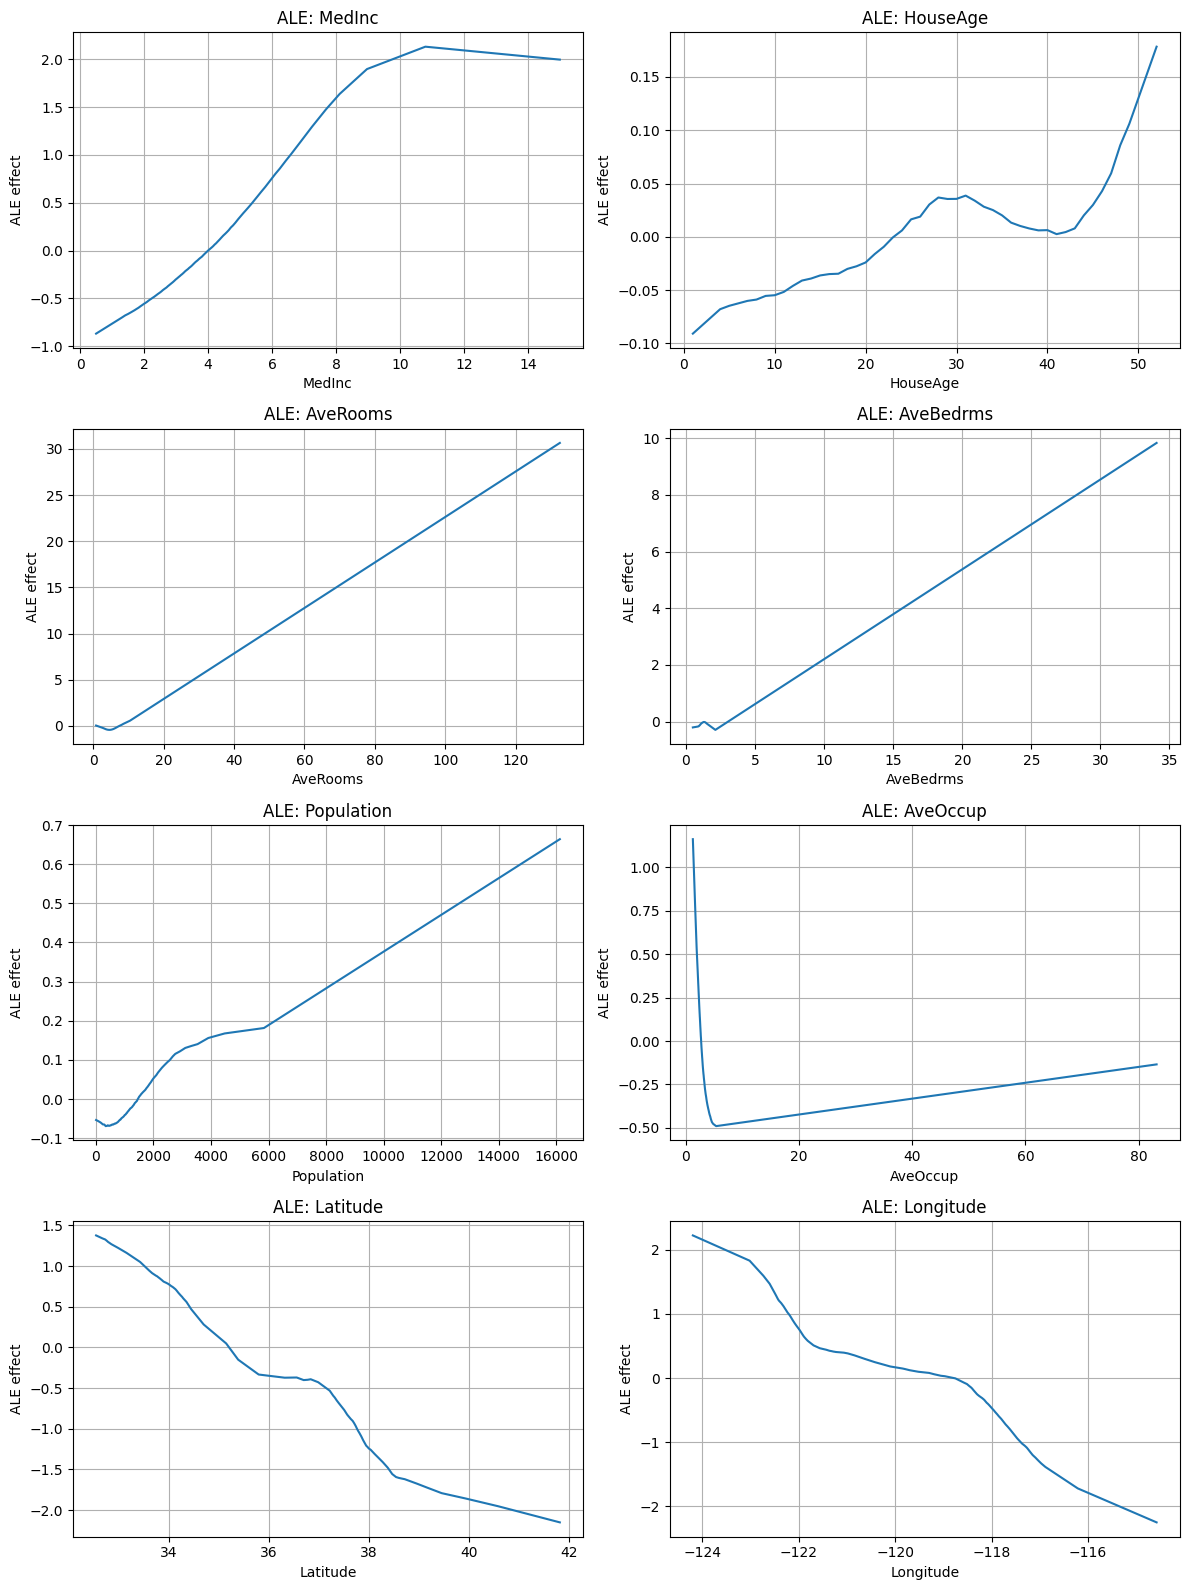

In [7]:
n_cols = 2
n_rows = -(-len(feature_names) // n_cols)  # ceiling division
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)

for idx, feature_name in enumerate(feature_names):
    ax = axs[idx // n_cols][idx % n_cols]

    # Compute ALE effect
    ale_eff, bin_intervals, _ = ale(
        X=X_test,
        model=pipe,
        feature=feature_name,
        grid_size=100,
    )

    intervals = list(bin_intervals.left) + [bin_intervals.right[-1]] # For x axis

    ax.plot(intervals, ale_eff)
    ax.set_title(f"ALE: {feature_name}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("ALE effect")
    ax.grid(True)

# Turn off any unused axes
for i in range(len(feature_names), n_rows * n_cols):
    axs[i // n_cols][i % n_cols].axis("off")

plt.tight_layout()
plt.savefig("ale.png")
plt.show()

## Study effect of using quantiles vs linear bins

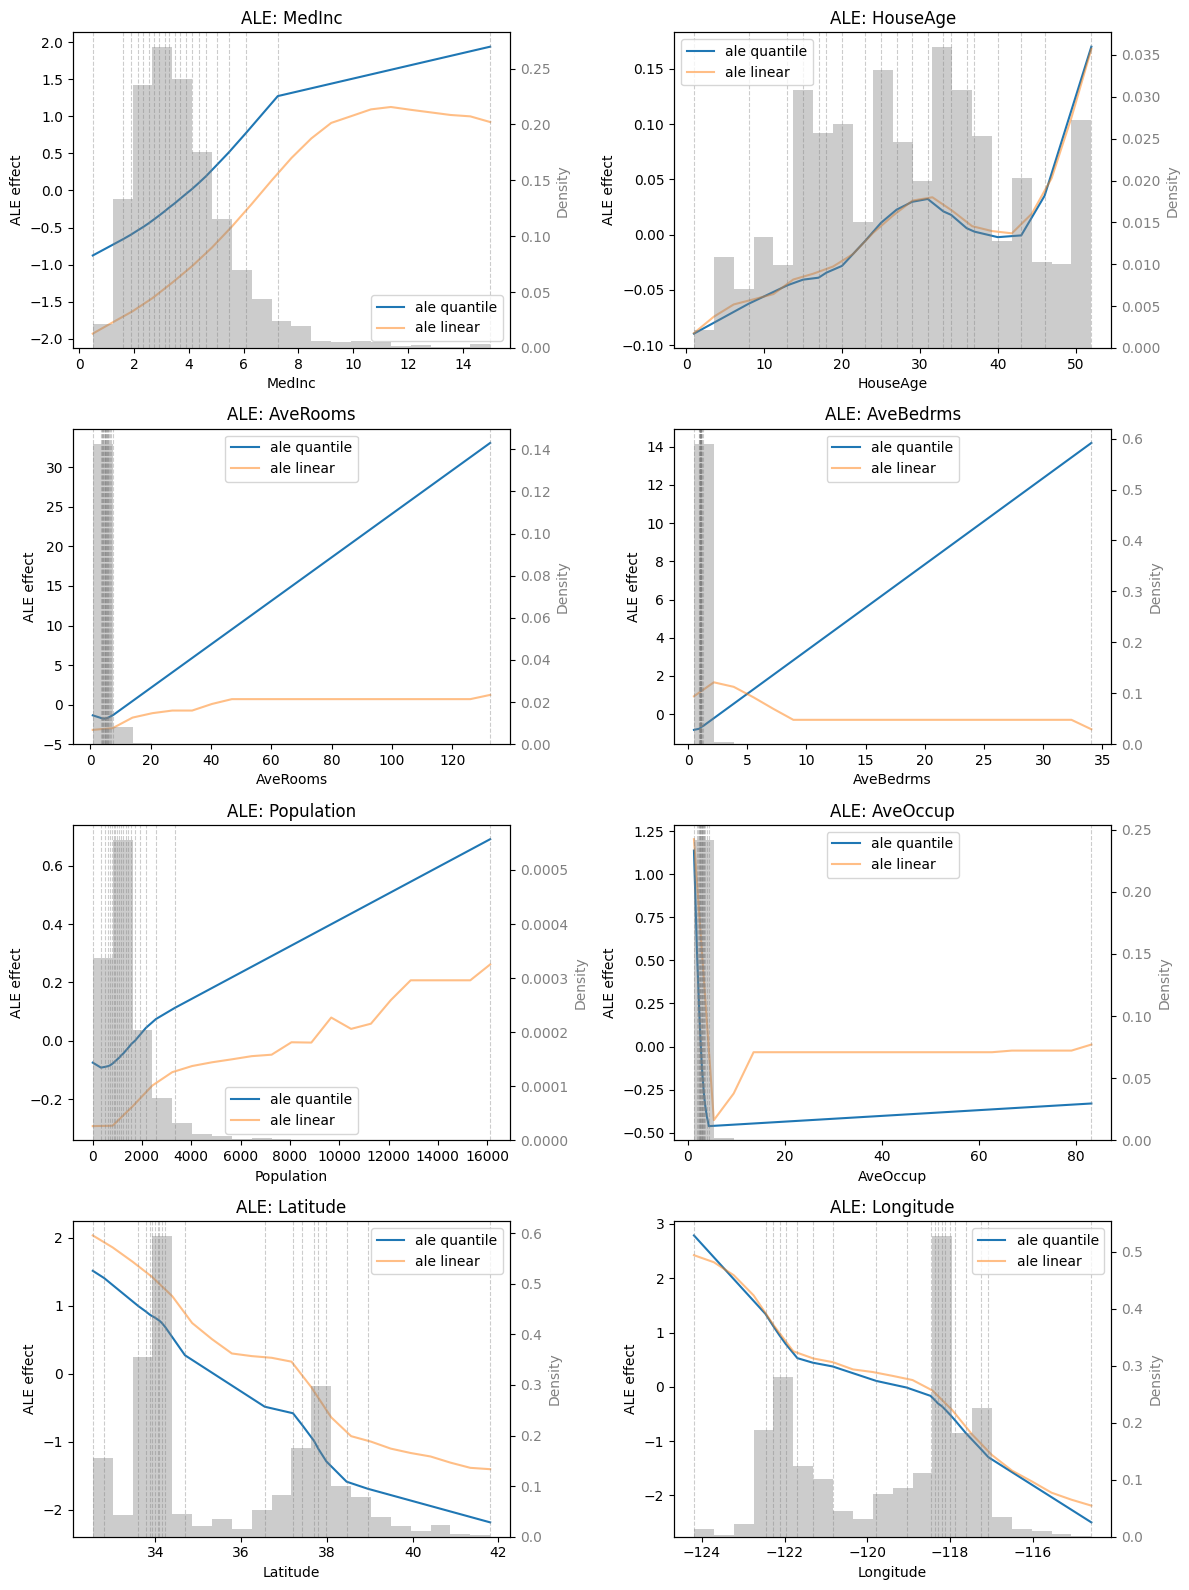

In [8]:
n_cols = 2
n_rows = -(-len(feature_names) // n_cols)  # ceiling division
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)

ale_effects = {}
ale_effects_linear = {}

ale_intervals = {}
ale_intervals_linear = {}

for idx, feature in enumerate(feature_names):
    ax = axs[idx // n_cols][idx % n_cols]

    # Compute ALE effect
    ale_eff, bin_intervals, delta_mean = ale(
        X=X_test,
        model=pipe,
        feature=feature,
        grid_size=20,
    )
    ale_eff_linear, bin_intervals_linear, delta_mean_linear = ale(
        X=X_test,
        model=pipe,
        feature=feature,
        grid_size=20,
        bin_method="linear",
    )

    intervals = list(bin_intervals.left) + [bin_intervals.right[-1]] # For x axis labels
    intervals_linear = list(bin_intervals_linear.left) + [bin_intervals_linear.right[-1]] # For x axis labels

    ale_effects[feature] = ale_eff
    ale_effects_linear[feature] = ale_eff_linear
    ale_intervals[feature] = intervals
    ale_intervals_linear[feature] = intervals_linear

    interval_widths = list(bin_intervals.right - bin_intervals.left)

    # Manually plot ALE curve on the given axis
    ax.plot(intervals, ale_eff, label="ale quantile")
    ax.plot(intervals_linear, ale_eff_linear, alpha=0.5, label="ale linear")

    # play with this one
    #for xline in intervals_linear:
    for xline in intervals:
        ax.axvline(x=xline, color="gray", linestyle="--", alpha=0.4, linewidth=0.8)

    ax.set_title(f"ALE: {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("ALE effect")
    ax.grid(False)
    ax.legend()

    ax_hist = ax.twinx()
    ax_hist.hist(
        X_test[feature],
        bins=20,
        color="gray",
        alpha=0.4,
        density=True,     # so it scales nicely with ALE curve
    )
    ax_hist.set_ylabel("Density", color="gray")
    ax_hist.tick_params(axis='y', labelcolor='gray')

# Turn off any unused axes
for i in range(len(feature_names), n_rows * n_cols):
    axs[i // n_cols][i % n_cols].axis("off")

plt.tight_layout()
plt.savefig("ale.png")
plt.show()

### Homework part 3

In [9]:
import shap

In [10]:
background = X_train
explainer = shap.Explainer(pipe.predict, background)
shap_values = explainer(X_test)

ExactExplainer explainer: 4129it [02:27, 26.86it/s]                          


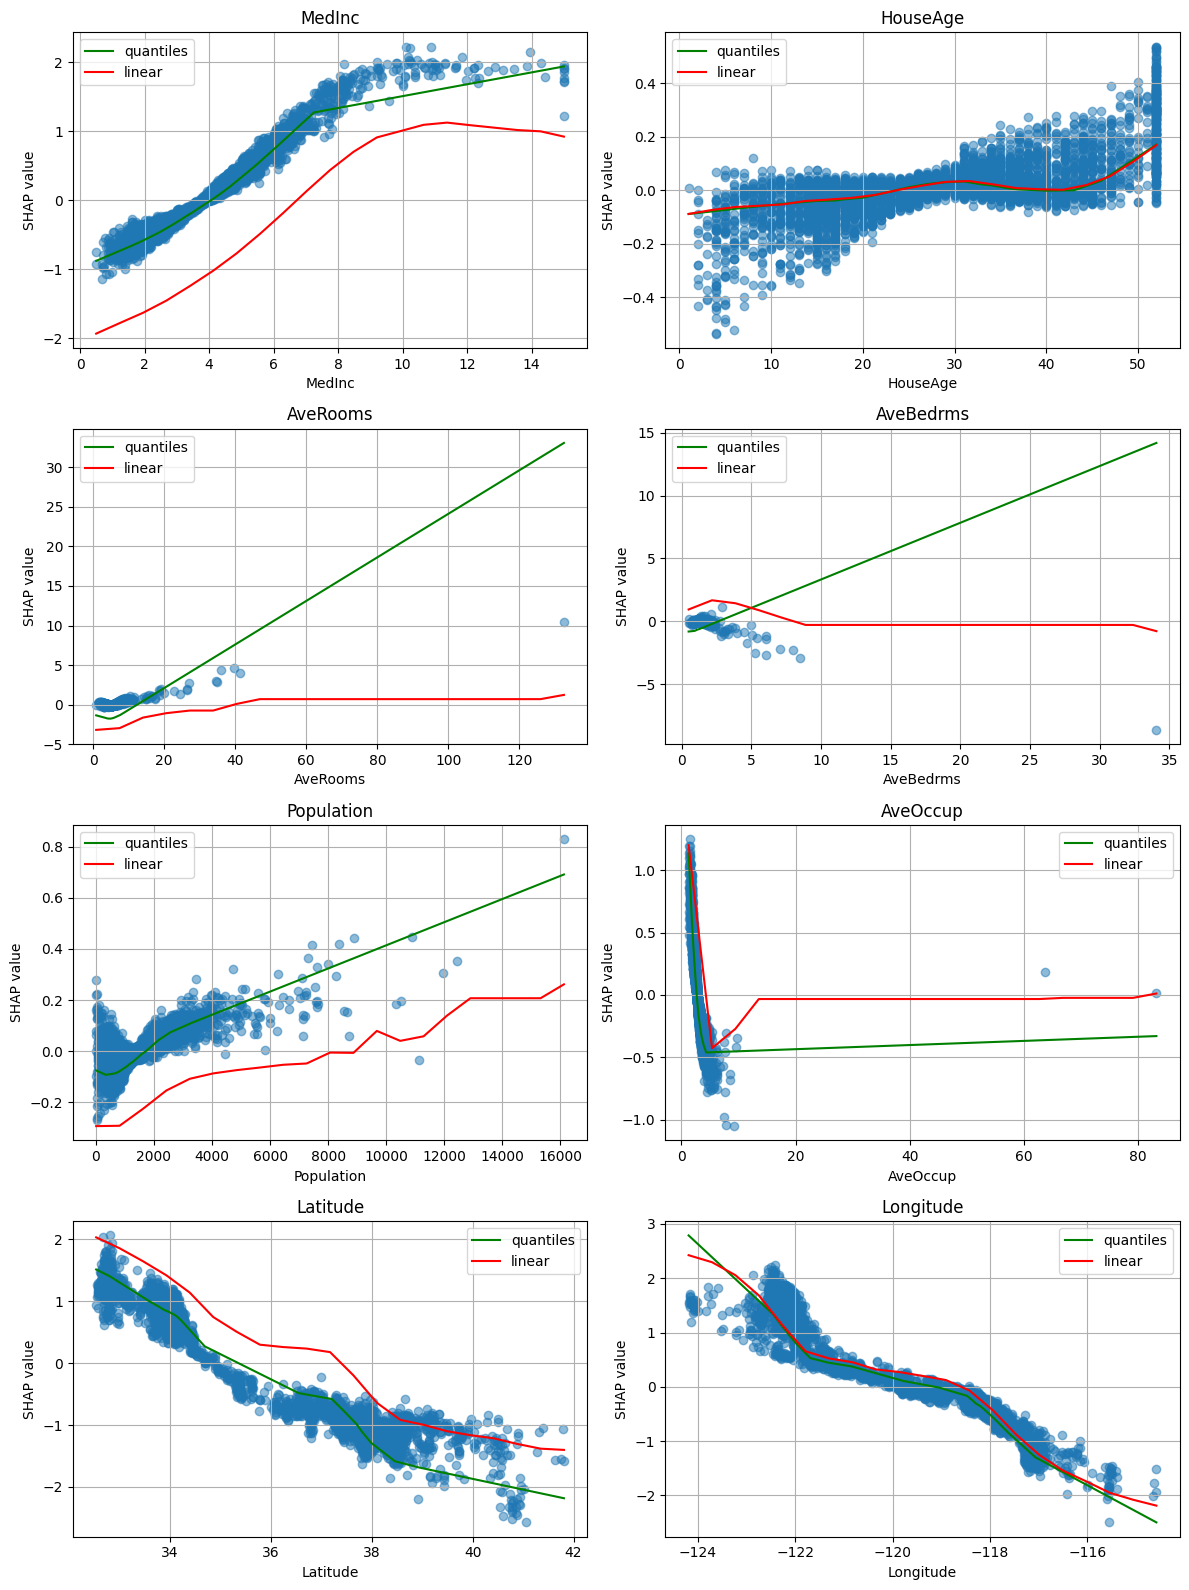

In [11]:
n_cols = 2
n_rows = -(-len(feature_names) // n_cols)  # ceiling division
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)

for idx, feature_name in enumerate(feature_names):
    ax = axs[idx // n_cols][idx % n_cols]

    feature_index = X_test.columns.get_loc(feature_name)
    shap_vals_feature = shap_values.values[:, feature_index]
    feature_values = X_test[feature_name].values

    ax.plot(ale_intervals[feature_name], ale_effects[feature_name], color="green", label="quantiles")
    ax.plot(ale_intervals_linear[feature_name], ale_effects_linear[feature_name], color="red", label="linear")
    ax.scatter(feature_values, shap_vals_feature, alpha=0.5)
    ax.set_xlabel(feature_name)
    ax.set_ylabel("SHAP value")
    ax.set_title(f"{feature_name}")
    ax.grid(True)
    ax.legend()

# Turn off any unused axes
for i in range(len(feature_names), n_rows * n_cols):
    axs[i // n_cols][i % n_cols].axis("off")

plt.tight_layout()
plt.show()